# Tornado Synthetic Dataset - 3D Steady
> [cgl datasets](https://cgl.ethz.ch/research/visualization/data.php)
> Steady means no time is involved

In [1]:
import numpy as np
import pyvista as pv
# np.set_printoptions(precision=3)

In [2]:
file = '..\\Data\\tornado3d.vti'
mesh = pv.read(file)
print(mesh)

UniformGrid (0x1705d402460)
  N Cells:	2048383
  N Points:	2097152
  X Bounds:	-1.000e+01, 1.000e+01
  Y Bounds:	-1.000e+01, 1.000e+01
  Z Bounds:	-1.000e+01, 1.000e+01
  Dimensions:	128, 128, 128
  Spacing:	1.575e-01, 1.575e-01, 1.575e-01
  N Arrays:	3



In [3]:
w,v,u = mesh.point_data['w'], mesh.point_data['v'], mesh.point_data['u']

vectors = np.empty((mesh.n_points, 3))
vectors[:,0] = u
vectors[:,1] = v
vectors[:,2] = w

print(f'mesh dimensions : {mesh.dimensions}')
print(f'128 * 128 * 128 = {128*128*128}')
print(f'u shape : {u.shape}\nv shape : {v.shape}\nw shape : {w.shape}')
print(f'vectors shape : {vectors.shape}')

mesh dimensions : (128, 128, 128)
128 * 128 * 128 = 2097152
u shape : (2097152,)
v shape : (2097152,)
w shape : (2097152,)
vectors shape : (2097152, 3)


In [4]:
# https://docs.pyvista.org/api/core/_autosummary/pyvista.RectilinearGrid.streamlines.html

mesh['vectors'] = vectors

boundary = mesh.decimate_boundary().extract_all_edges()

# Sphere Source
stream_base, seed_pts = mesh.streamlines(
    'vectors', 
    return_source=True,
    n_points=20,
    source_radius=10,
    source_center=(0,0,0), 
    integration_direction='forward'
)

# Line Source
# stream, src = mesh.streamlines(
#     'vectors', 
#     return_source=True,
#     n_points=100,
#     pointa=(-8, -8, 10),
#     pointb=(8, 8, 10),
#     integration_direction='both',
#     terminal_speed=-1,
#     step_unit='l',
#     initial_step_length=.01,
#     max_steps=6000,
#     min_step_length=.01
# )

sargs=dict(vertical=True, title_font_size=16)
p = pv.Plotter()
p.add_mesh(stream_base.tube(radius=0.02), lighting=False, scalar_bar_args=sargs)
# p.add_mesh(src)
p.add_mesh(boundary, color='grey', opacity=.25)
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [5]:
print(stream_base.point_data)

pyvista DataSetAttributes
Association     : POINT
Active Scalars  : vectors
Active Vectors  : Normals
Active Texture  : None
Active Normals  : None
Contains arrays :
    u                       float32  (1178,)
    v                       float32  (1178,)
    w                       float32  (1178,)
    vectors                 float64  (1178, 3)            SCALARS
    IntegrationTime         float64  (1178,)
    Vorticity               float64  (1178, 3)
    Rotation                float64  (1178,)
    AngularVelocity         float64  (1178,)
    Normals                 float64  (1178, 3)            VECTORS


In [6]:
print(seed_pts)

PolyData (0x1705d402340)
  N Cells:	1
  N Points:	20
  X Bounds:	-7.917e+00, 9.066e+00
  Y Bounds:	-7.497e+00, 7.694e+00
  Z Bounds:	-8.336e+00, 9.187e+00
  N Arrays:	0



# First Sample of s=2

In [7]:
s = 2

ws,vs,us = mesh.point_data['w'], mesh.point_data['v'], mesh.point_data['u']

us.shape = mesh.dimensions
vs.shape = mesh.dimensions
ws.shape = mesh.dimensions

# Down Sample / Decimate
us = us[::s, ::s, ::s]
vs = vs[::s, ::s, ::s]
ws = ws[::s, ::s, ::s]

dims = us.shape

# Flatten vectors
us = us.flatten(order='F')
vs = vs.flatten(order='F')
ws = ws.flatten(order='F')

vectorss = np.empty((int(len(us)), 3))
vectorss[:,0] = us
vectorss[:,1] = vs
vectorss[:,2] = ws

mesh2 = pv.UniformGrid(
    dims=dims,
    spacing=tuple([x*s for x in list(mesh.spacing)]),
    origin=mesh.origin,
)

print(f'mesh2 dimensions : {mesh2.dimensions}')
print(f'(64 * 64 * 64)  = {(64*64*64)}')
print(f'us shape : {us.shape}\nvs shape : {vs.shape}\nws shape : {ws.shape}')
print(f'vectorss shape : {vectorss.shape}')

mesh2 dimensions : (64, 64, 64)
(64 * 64 * 64)  = 262144
us shape : (262144,)
vs shape : (262144,)
ws shape : (262144,)
vectorss shape : (262144, 3)


In [8]:
mesh2['vectorss'] = vectorss

# print(seed_pts.points)

stream2 = mesh.streamlines_from_source(
    vectors=vectorss, 
    source=seed_pts,
    integration_direction='forward'
)

boundary2 = mesh2.decimate_boundary().extract_all_edges()

sargs=dict(vertical=True, title_font_size=16)
p = pv.Plotter()
p.add_mesh(stream2.tube(radius=0.02), lighting=False, scalar_bar_args=sargs)
p.add_mesh(boundary2, color='grey', opacity=.25)
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

# Generate Error between Streamlines

In [18]:
idx = 0

stream_1 = stream_base.cell_points(idx)
stream_2 = stream2.cell_points(idx)

print(stream_1.shape)
print(stream_2.shape)

t_1 = stream_1[1:,:] - stream_1[:-1,:]
t_2 = stream_2[1:,:] - stream_2[:-1,:]
length_1 = sum([np.sqrt(x[0]**2 + x[1]**2 + x[2]**2) for x in t_1])
length_2 = sum([np.sqrt(x[0]**2 + x[1]**2 + x[2]**2) for x in t_2])
print(length_1)
print(length_2)


(97, 3)
(97, 3)
20.997811066619178
20.997811066619178


In [ ]:
t = np.linspace(0,1,stream_1.shape[0])

tvals = np.linspace(0,1,stream_1.shape[0]*5)

xinter1 = np.interp(tvals, t, stream_1[:,0])
yinter1 = np.interp(tvals, t, stream_1[:,1])
zinter1 = np.interp(tvals, t, stream_1[:,2])

xinter2 = np.interp(tvals, t, stream_2[:,0])
yinter2 = np.interp(tvals, t, stream_2[:,1])
zinter2 = np.interp(tvals, t, stream_2[:,2])

mag_inter1 = [np.sqrt(x**2 + y**2 + z**2) for x,y,z in zip(xinter1, yinter1, zinter1)]
mag_inter2 = [np.sqrt(x**2 + y**2 + z**2) for x,y,z in zip(xinter2, yinter2, zinter2)]

error = [abs(mag1 - mag2) for mag1, mag2 in zip(mag_inter1, mag_inter2)]

In [27]:
errors = []
for i in range(stream_base.n_cells):
    stream_1 = stream_base.cell_points(i).copy()
    stream_2 = stream2.cell_points(i).copy()
    print(f'Stream 1 : {stream_1.shape}\nStream 2 : {stream_2.shape}\n')
    
    # Distance between each point in streamline
    t_1 = stream_1[1:,:] - stream_1[:-1,:]
    t_2 = stream_2[1:,:] - stream_2[:-1,:]
   
     # Lengths of streamlines
    length_1 = sum([np.sqrt(x[0]**2 + x[1]**2 + x[2]**2) for x in t_1])
    length_2 = sum([np.sqrt(x[0]**2 + x[1]**2 + x[2]**2) for x in t_2])
    print(f'Stream 1 Length: {length_1}\nStream 2 Length : {length_2}\n')
    

    # Want to interpolate by 5 points greater than # of points in streamline
    tvals = np.linspace(0,1,stream_1.shape[0]*5)
    t = np.linspace(0,1,stream_1.shape[0])

    xinter1 = np.interp(tvals, t, stream_1[:,0])
    yinter1 = np.interp(tvals, t, stream_1[:,1])
    zinter1 = np.interp(tvals, t, stream_1[:,2])

    xinter2 = np.interp(tvals, t, stream_2[:,0])
    yinter2 = np.interp(tvals, t, stream_2[:,1])
    zinter2 = np.interp(tvals, t, stream_2[:,2])

    # Get magnitude of points so can calculate error
    mag_inter1 = [np.sqrt(x**2 + y**2 + z**2) for x,y,z in zip(xinter1, yinter1, zinter1)]
    mag_inter2 = [np.sqrt(x**2 + y**2 + z**2) for x,y,z in zip(xinter2, yinter2, zinter2)]

    errors.append([abs(mag1 - mag2) for mag1, mag2 in zip(mag_inter1, mag_inter2)])

Stream 1 : (97, 3)
Stream 2 : (97, 3)

Stream 1 Length: 20.997811066619178
Stream 2 Length : 20.997811066619178

Stream 1 : (76, 3)
Stream 2 : (76, 3)

Stream 1 Length: 16.693564294592637
Stream 2 Length : 16.693564294592637

Stream 1 : (128, 3)
Stream 2 : (128, 3)

Stream 1 Length: 20.486516189332303
Stream 2 Length : 20.486516189332303

Stream 1 : (34, 3)
Stream 2 : (34, 3)

Stream 1 Length: 8.544645920040267
Stream 2 Length : 8.544645920040267

Stream 1 : (105, 3)
Stream 2 : (105, 3)

Stream 1 Length: 19.913537985628324
Stream 2 Length : 19.913537985628324

Stream 1 : (7, 3)
Stream 2 : (7, 3)

Stream 1 Length: 1.6365530357348155
Stream 2 Length : 1.6365530357348155

Stream 1 : (20, 3)
Stream 2 : (20, 3)

Stream 1 Length: 4.733414546735736
Stream 2 Length : 4.733414546735736

Stream 1 : (34, 3)
Stream 2 : (34, 3)

Stream 1 Length: 7.286716140027696
Stream 2 Length : 7.286716140027696

Stream 1 : (114, 3)
Stream 2 : (114, 3)

Stream 1 Length: 21.076802271221855
Stream 2 Length : 21.07

In [47]:
# errors = []
# for i in range(stream_base.n_cells):
#     points1 = stream_base.cell_points(i).deepcopy()
#     points2 = stream2.cell_points(i)
#     small = min(points1.shape[0], points2.shape[0])
#     if points1.shape[0] == small:
#         print(f'min : {small}\npoints2 shape : {points2.shape}\npoints1 shape : {points1.shape}')
#         points2 = points2[:small, :]
#     else:
#         points1 = points1[:small, :]
#         print(f'min : {small}\npoints1 shape : {points1.shape}\npoints2 shape : {points2.shape}')
#     errors.append(abs(points1 - points2))
  
# # for error in errors[:-1]: 
# #     print(error)
# mag_errors = []
# for points in errors:
#     mag_errors.append([np.sqrt(error[0]**2 + error[1]**2 + error[2]**2) for error in points])

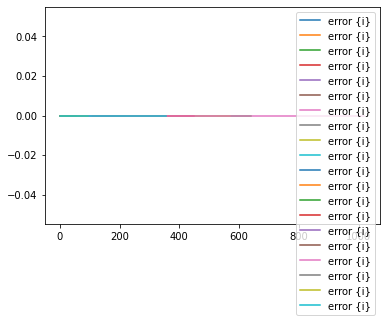

In [30]:
import matplotlib.pyplot as plt
for i in range(len(errors)):
    plt.plot(errors[i], label="error {i}")
plt.legend()
plt.show()